In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tools import bootstrap_ci
from joblib import Parallel, delayed
import h5py
from tqdm.notebook import tqdm,trange
sns.set_context("poster")

In [9]:
hdf5_filename= "results.h5"

In [10]:
prol_data = pd.read_csv("responses.csv")
prol_data["advice"]=prol_data["advice"].astype(float)

In [11]:
alg_styles = (
    ("exp4", "C2", "EXP4", '^'),
    ("random_expert", "C4", "random expert", 'D'),
    ("WMV", "C1", "WMV", 'v'),
    ("expert_0", "C7", "best expert", '>'),
    ("MetaCMAB", "C0", "MetaCMAB", '<'),
    ("ExpertiseTree", "black", "ExpertiseTree", 'p'),
)


def get_all_results(k, subset_size, treatment=None):

    if k == "random_expert":
        results = []
        for i in range(subset_size):
            results.append(get_all_results(f"expert_{i}",subset_size,treatment))
        randomly_chosen_experts = np.random.choice(np.shape(results)[0],np.shape(results)[1])

        results = [results[r][j] for j,r in enumerate(randomly_chosen_experts)]
        return np.array(results)
    with h5py.File(hdf5_filename, 'r') as hf:
        if f"{subset_size} {0} {k}" not in hf:
            return None
        results = []
        for tr in range(5):
            data = hf[f"{subset_size} {tr} {k}"]
            if tr == treatment:
                return np.array(data)

            results.extend(np.array(data).reshape((-1, 16)))

        return np.array(results)

def print_summary(SUBSET_SIZE):
    print("algorithm"+" "*max(1, 35-len("algorithm")), "  mean", "  final")
    print("----------------------------------------------")
    with h5py.File(hdf5_filename, 'r') as hf:

        algorithms = set([" ".join(key.split()[2:])
                         for key in hf.keys() if key.split()[0] == str(SUBSET_SIZE)])

        for k in sorted(algorithms):
            try:
                all_results = get_all_results(k, SUBSET_SIZE)
                reward_mean = np.mean(all_results)
                final_reward_mean = np.mean(all_results[..., -1:])

                print(k+" "*max(1, 35-len(k)), f"{reward_mean:.4f}", f"{final_reward_mean:.4f}")
            except:
                print("skipping", k)


def plot_subset_figures(SUBSET_SIZE):
    os.makedirs("figures", exist_ok=True)

    def transform(a):
        ref_key = "expert_0"
        if mode == "instantaneous regret":
            return np.array(get_all_results(ref_key, SUBSET_SIZE))-a
        if mode == "regret":
            a = np.array(get_all_results(ref_key, SUBSET_SIZE))-a
            return np.cumsum(a, axis=1)
        if mode == "average":
            return np.cumsum(a,axis=1)/np.arange(1,len(a[0])+1)
      
        return a

    def plot_k_c(alg_key, alg_color, alg_label, alg_marker):
        metric = transform(np.array(get_all_results(alg_key, SUBSET_SIZE)))
        mean = metric.mean(axis=0)

        lower_bound, upper_bound = np.array(
            [bootstrap_ci(metric[:, i],n_bootstraps=1000) for i in range(T)]).T

        plt.plot(np.arange(len(mean))*3, (mean), color=alg_color, label=alg_label,
                 linestyle="--" if alg_label not in ("MetaCMAB", "ExpertiseTree") else "-", marker=alg_marker,
                 linewidth=4, markersize=8 if alg_marker == 'D' else 10)
        plt.fill_between(x=np.arange(len(mean))*3, y1=lower_bound,
                         y2=upper_bound, color=alg_color, alpha=0.2)

    for mode in ( "instantaneous regret",):

        for alg_key, alg_color, alg_label, alg_marker in alg_styles:
            if get_all_results(alg_key, SUBSET_SIZE) is None:
                continue

            plot_k_c(alg_key, alg_color, alg_label, alg_marker)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.ylabel(mode.replace("reward", "accuracy"))
        plt.xlabel("#headlines")

        if mode in ("reward", "average"):
            plt.yticks([0.5, 0.6, .7, .8, .9])

        if mode == "instantaneous regret":
            plt.ylim(-0.12, 0.3)
            plt.yticks([-0.1, 0, .1, .2, .3])

        plt.gca().set_box_aspect(1)
        sns.despine(offset=0,)

        plt.savefig(f"figures/{mode}_{SUBSET_SIZE}.pdf", bbox_inches="tight")
        plt.savefig(f"figures/{mode}_{SUBSET_SIZE}.svg", bbox_inches="tight")
        plt.show()

In [12]:
from agent import *
from policy import *


class GreedyExpert():
    def __init__(self, expert_index, performance_index):
        self.expert_index = expert_index
        self.performance_index = performance_index

    def choose(self, advice):
        play_advice = advice["advice"][self.expert_index]
        probs = greedy_choice(play_advice)
        return np.searchsorted(np.cumsum(probs), np.random.rand(1))[0]

    def update(self, rewards, action):
        pass

    def reset(self):
        pass


def run_simulation(
    advice,
    outcomes,
    contexts,
    agent,
    seed,
    subset_size,
    n_simulations=100
):
    np.random.seed(seed)
    run_seeds = np.random.randint(0, 1000000, size=n_simulations)
    n_trials, n_arms, n_experts = advice.shape

    np.random.seed(seed)

    assert 0 < subset_size <= n_experts

    simulation_subsets = [np.random.choice(
        n_experts, size=subset_size, replace=False) for _ in range(n_simulations)]

    rewards = []

    for run_seed, subset in tqdm(zip(run_seeds, simulation_subsets), total=n_simulations, desc="inner", disable=True):

        np.random.seed(run_seed)
        rewards.append([])

        t_order = np.random.choice(n_trials, size=n_trials, replace=False)

        sim_advice = advice[t_order][..., subset]
        sim_outcomes = outcomes[t_order][..., subset]
        sim_contexts = contexts[t_order]

        # assign appropriate expert
        if type(agent) == GreedyExpert:
            expert_votes = greedy_choice(sim_advice, axis=1)
            expert_rewards = (expert_votes * sim_outcomes).sum(axis=1)
            agent.expert_index = np.argsort(-expert_rewards.sum(axis=0))[
                agent.performance_index]

        agent.reset()
        for t in range(n_trials):
            np.random.seed(run_seed + t)

            trial_rewards = sim_outcomes[t][..., 0]

            choice = agent.choose(
                {"advice": sim_advice[t].T, "context": sim_contexts[t]})
            agent.update(trial_rewards, choice)

            rewards[-1].append(trial_rewards[choice])

    return rewards

In [13]:
subset_sizes = np.arange(2,37,2).tolist()

subset sizes:   0%|          | 0/18 [00:00<?, ?it/s]

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/6 [00:00<?, ?it/s]

aggregators:   0%|          | 0/6 [00:00<?, ?it/s]

aggregators:   0%|          | 0/6 [00:00<?, ?it/s]

aggregators:   0%|          | 0/6 [00:00<?, ?it/s]

aggregators:   0%|          | 0/6 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.5938 0.6068
MetaCMAB                            0.5838 0.5868
WMV                                 0.5741 0.5776
exp4                                0.5741 0.5770
expert_0                            0.6294 0.6206
expert_1                            0.4919 0.4790


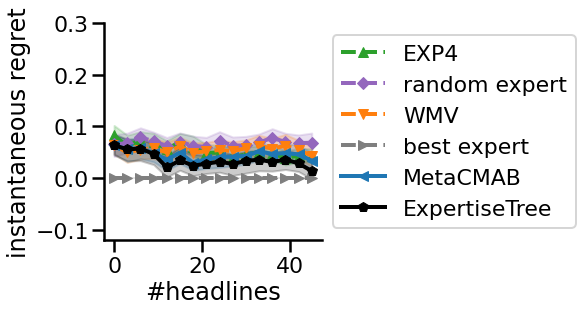

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/8 [00:00<?, ?it/s]

aggregators:   0%|          | 0/8 [00:00<?, ?it/s]

aggregators:   0%|          | 0/8 [00:00<?, ?it/s]

aggregators:   0%|          | 0/8 [00:00<?, ?it/s]

aggregators:   0%|          | 0/8 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.6289 0.6572
MetaCMAB                            0.6123 0.6252
WMV                                 0.5894 0.5904
exp4                                0.5834 0.5884
expert_0                            0.6811 0.6782
expert_1                            0.5989 0.5856
expert_2                            0.5268 0.5118
expert_3                            0.4347 0.4214


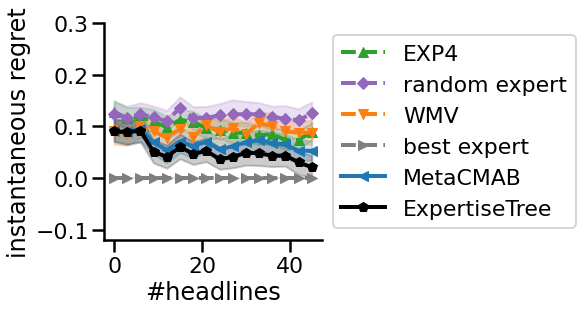

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/10 [00:00<?, ?it/s]

aggregators:   0%|          | 0/10 [00:00<?, ?it/s]

aggregators:   0%|          | 0/10 [00:00<?, ?it/s]

aggregators:   0%|          | 0/10 [00:00<?, ?it/s]

aggregators:   0%|          | 0/10 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.6501 0.6908
MetaCMAB                            0.6287 0.6480
WMV                                 0.5970 0.5954
exp4                                0.5881 0.5924
expert_0                            0.7103 0.7024
expert_1                            0.6385 0.6266
expert_2                            0.5889 0.5730
expert_3                            0.5427 0.5322
expert_4                            0.4857 0.4702
expert_5                            0.4040 0.3944


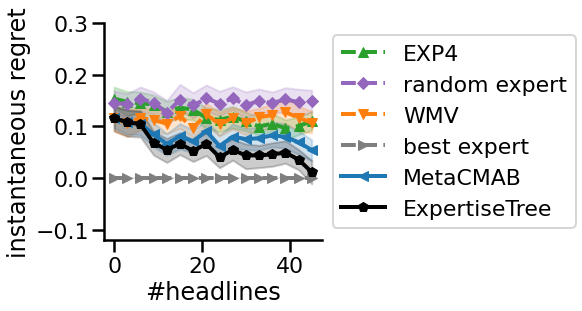

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/12 [00:00<?, ?it/s]

aggregators:   0%|          | 0/12 [00:00<?, ?it/s]

aggregators:   0%|          | 0/12 [00:00<?, ?it/s]

aggregators:   0%|          | 0/12 [00:00<?, ?it/s]

aggregators:   0%|          | 0/12 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.6678 0.7062
MetaCMAB                            0.6416 0.6594
WMV                                 0.6006 0.5952
exp4                                0.5895 0.5942
expert_0                            0.7267 0.7190
expert_1                            0.6633 0.6496
expert_2                            0.6185 0.5990
expert_3                            0.5840 0.5790
expert_4                            0.5497 0.5298
expert_5                            0.5084 0.4922
expert_6                            0.4580 0.4434
expert_7                            0.3834 0.3780


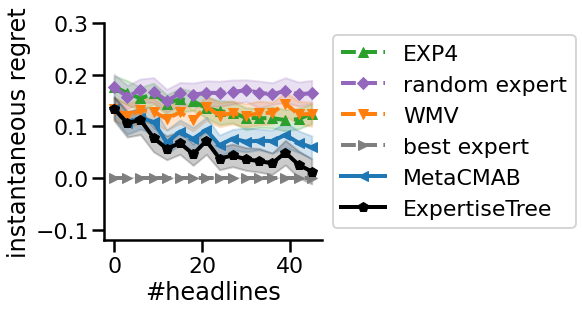

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/14 [00:00<?, ?it/s]

aggregators:   0%|          | 0/14 [00:00<?, ?it/s]

aggregators:   0%|          | 0/14 [00:00<?, ?it/s]

aggregators:   0%|          | 0/14 [00:00<?, ?it/s]

aggregators:   0%|          | 0/14 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.6825 0.7370
MetaCMAB                            0.6518 0.6660
WMV                                 0.6030 0.6006
exp4                                0.5923 0.5982
expert_0                            0.7389 0.7296
expert_1                            0.6812 0.6690
expert_2                            0.6393 0.6208
expert_3                            0.6092 0.5902
expert_4                            0.5811 0.5722
expert_5                            0.5538 0.5424
expert_6                            0.5205 0.5078
expert_7                            0.4830 0.4656
expert_8                            0.4383 0.4238
expert_9                            0.3685 0.3620


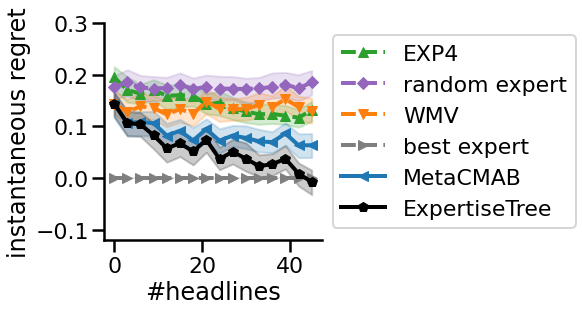

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/16 [00:00<?, ?it/s]

aggregators:   0%|          | 0/16 [00:00<?, ?it/s]

aggregators:   0%|          | 0/16 [00:00<?, ?it/s]

aggregators:   0%|          | 0/16 [00:00<?, ?it/s]

aggregators:   0%|          | 0/16 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.6931 0.7516
MetaCMAB                            0.6606 0.6918
WMV                                 0.6028 0.6046
exp4                                0.5931 0.5972
expert_0                            0.7489 0.7466
expert_1                            0.6941 0.6784
expert_10                           0.4241 0.4036
expert_11                           0.3559 0.3528
expert_2                            0.6547 0.6420
expert_3                            0.6259 0.6024
expert_4                            0.6029 0.5896
expert_5                            0.5805 0.5702
expert_6                            0.5558 0.5380
expert_7                            0.5296 0.5220
expert_8                            0.4983 0.4812
expert_9                            0.4644 0.4562


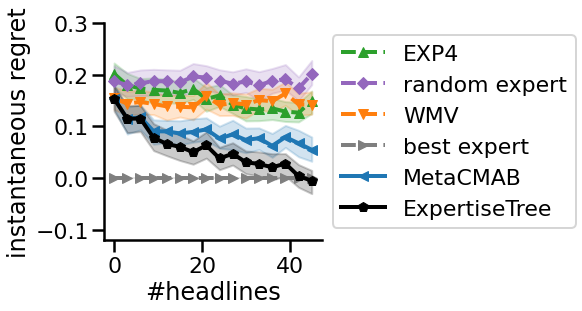

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/18 [00:00<?, ?it/s]

aggregators:   0%|          | 0/18 [00:00<?, ?it/s]

aggregators:   0%|          | 0/18 [00:00<?, ?it/s]

aggregators:   0%|          | 0/18 [00:00<?, ?it/s]

aggregators:   0%|          | 0/18 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7035 0.7622
MetaCMAB                            0.6705 0.7066
WMV                                 0.6033 0.6020
exp4                                0.5930 0.5972
expert_0                            0.7563 0.7486
expert_1                            0.7051 0.6934
expert_10                           0.4811 0.4710
expert_11                           0.4491 0.4388
expert_12                           0.4118 0.3932
expert_13                           0.3455 0.3434
expert_2                            0.6684 0.6626
expert_3                            0.6381 0.6178
expert_4                            0.6171 0.5960
expert_5                            0.5972 0.5874
expert_6                            0.5786 0.5608
expert_7                            0.5585 0.5476
expert_8                            0.5356 0.5272
expert_9                            0.5098 0.4956


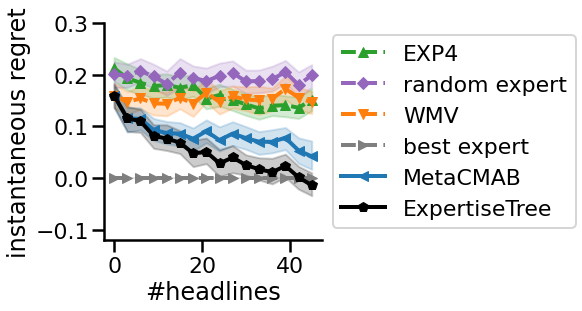

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/20 [00:00<?, ?it/s]

aggregators:   0%|          | 0/20 [00:00<?, ?it/s]

aggregators:   0%|          | 0/20 [00:00<?, ?it/s]

aggregators:   0%|          | 0/20 [00:00<?, ?it/s]

aggregators:   0%|          | 0/20 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7133 0.7814
MetaCMAB                            0.6761 0.7062
WMV                                 0.6025 0.6008
exp4                                0.5938 0.5960
expert_0                            0.7624 0.7540
expert_1                            0.7147 0.6998
expert_10                           0.5185 0.5092
expert_11                           0.4930 0.4804
expert_12                           0.4677 0.4620
expert_13                           0.4375 0.4210
expert_14                           0.4019 0.3876
expert_15                           0.3367 0.3366
expert_2                            0.6799 0.6786
expert_3                            0.6504 0.6378
expert_4                            0.6286 0.6050
expert_5                            0.6090 0.5908
expert_6                            0.5938 0.5856
expert_7                            0.5776 0.5574
ex

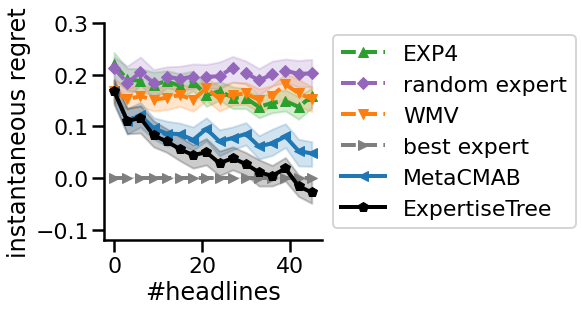

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/22 [00:00<?, ?it/s]

aggregators:   0%|          | 0/22 [00:00<?, ?it/s]

aggregators:   0%|          | 0/22 [00:00<?, ?it/s]

aggregators:   0%|          | 0/22 [00:00<?, ?it/s]

aggregators:   0%|          | 0/22 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7203 0.7906
MetaCMAB                            0.6840 0.7236
WMV                                 0.6011 0.6000
exp4                                0.5954 0.5908
expert_0                            0.7671 0.7570
expert_1                            0.7230 0.7084
expert_10                           0.5450 0.5326
expert_11                           0.5276 0.5236
expert_12                           0.5039 0.4884
expert_13                           0.4804 0.4624
expert_14                           0.4543 0.4524
expert_15                           0.4288 0.4120
expert_16                           0.3945 0.3806
expert_17                           0.3290 0.3272
expert_2                            0.6910 0.6868
expert_3                            0.6596 0.6452
expert_4                            0.6388 0.6182
expert_5                            0.6210 0.6086
ex

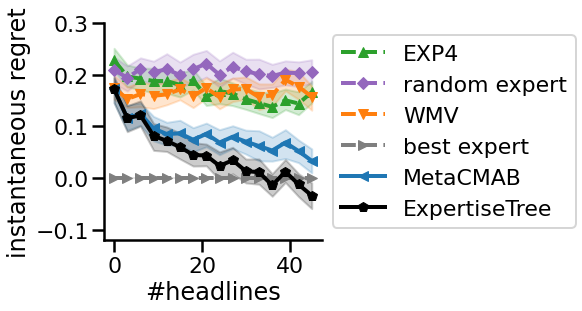

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/24 [00:00<?, ?it/s]

aggregators:   0%|          | 0/24 [00:00<?, ?it/s]

aggregators:   0%|          | 0/24 [00:00<?, ?it/s]

aggregators:   0%|          | 0/24 [00:00<?, ?it/s]

aggregators:   0%|          | 0/24 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7276 0.7960
MetaCMAB                            0.6908 0.7280
WMV                                 0.6026 0.5976
exp4                                0.5969 0.5974
expert_0                            0.7717 0.7642
expert_1                            0.7295 0.7122
expert_10                           0.5632 0.5514
expert_11                           0.5474 0.5332
expert_12                           0.5308 0.5266
expert_13                           0.5138 0.4960
expert_14                           0.4901 0.4780
expert_15                           0.4682 0.4514
expert_16                           0.4464 0.4426
expert_17                           0.4202 0.4004
expert_18                           0.3876 0.3690
expert_19                           0.3222 0.3238
expert_2                            0.6998 0.6902
expert_3                            0.6699 0.6636
ex

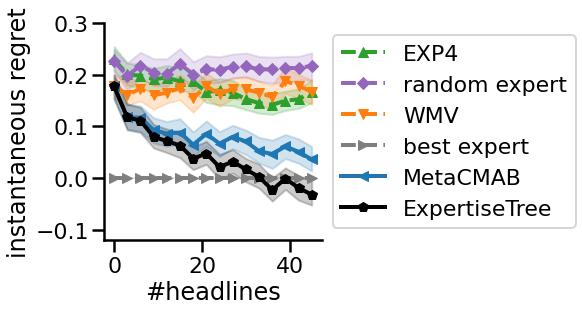

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/26 [00:00<?, ?it/s]

aggregators:   0%|          | 0/26 [00:00<?, ?it/s]

aggregators:   0%|          | 0/26 [00:00<?, ?it/s]

aggregators:   0%|          | 0/26 [00:00<?, ?it/s]

aggregators:   0%|          | 0/26 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7343 0.8108
MetaCMAB                            0.6955 0.7394
WMV                                 0.6031 0.5970
exp4                                0.5965 0.5994
expert_0                            0.7748 0.7694
expert_1                            0.7351 0.7182
expert_10                           0.5748 0.5736
expert_11                           0.5631 0.5476
expert_12                           0.5490 0.5324
expert_13                           0.5364 0.5226
expert_14                           0.5189 0.5064
expert_15                           0.5011 0.4904
expert_16                           0.4786 0.4644
expert_17                           0.4592 0.4392
expert_18                           0.4371 0.4262
expert_19                           0.4137 0.3958
expert_2                            0.7070 0.6944
expert_20                           0.3818 0.3676
ex

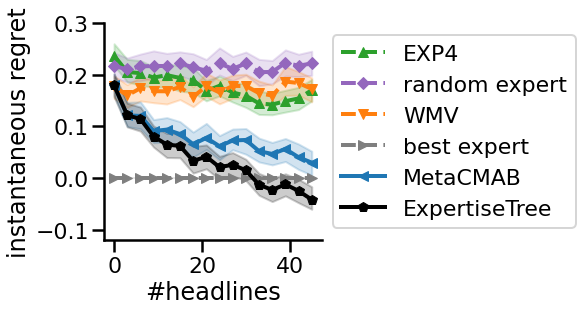

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/28 [00:00<?, ?it/s]

aggregators:   0%|          | 0/28 [00:00<?, ?it/s]

aggregators:   0%|          | 0/28 [00:00<?, ?it/s]

aggregators:   0%|          | 0/28 [00:00<?, ?it/s]

aggregators:   0%|          | 0/28 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7397 0.8176
MetaCMAB                            0.7016 0.7496
WMV                                 0.6025 0.5976
exp4                                0.5964 0.6006
expert_0                            0.7782 0.7734
expert_1                            0.7399 0.7258
expert_10                           0.5867 0.5658
expert_11                           0.5740 0.5558
expert_12                           0.5631 0.5488
expert_13                           0.5522 0.5396
expert_14                           0.5391 0.5234
expert_15                           0.5251 0.5162
expert_16                           0.5071 0.4926
expert_17                           0.4889 0.4738
expert_18                           0.4702 0.4570
expert_19                           0.4504 0.4234
expert_2                            0.7138 0.6980
expert_20                           0.4322 0.4258
ex

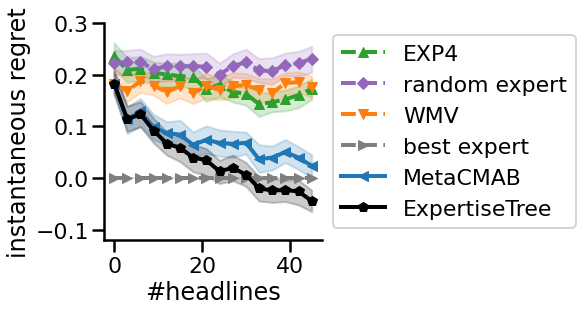

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/30 [00:00<?, ?it/s]

aggregators:   0%|          | 0/30 [00:00<?, ?it/s]

aggregators:   0%|          | 0/30 [00:00<?, ?it/s]

aggregators:   0%|          | 0/30 [00:00<?, ?it/s]

aggregators:   0%|          | 0/30 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7463 0.8310
MetaCMAB                            0.7053 0.7580
WMV                                 0.6022 0.5948
exp4                                0.5950 0.6002
expert_0                            0.7812 0.7742
expert_1                            0.7442 0.7258
expert_10                           0.5938 0.5672
expert_11                           0.5843 0.5758
expert_12                           0.5739 0.5540
expert_13                           0.5631 0.5500
expert_14                           0.5541 0.5428
expert_15                           0.5437 0.5280
expert_16                           0.5289 0.5084
expert_17                           0.5129 0.5042
expert_18                           0.4955 0.4752
expert_19                           0.4792 0.4682
expert_2                            0.7196 0.7062
expert_20                           0.4611 0.4452
ex

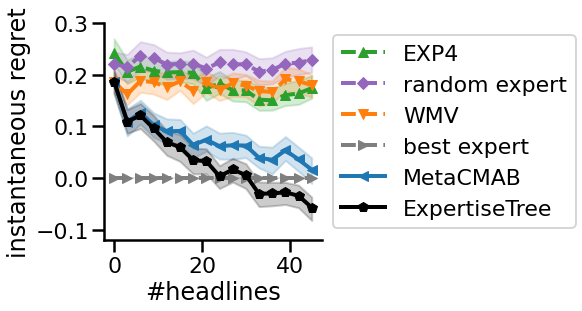

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/32 [00:00<?, ?it/s]

aggregators:   0%|          | 0/32 [00:00<?, ?it/s]

aggregators:   0%|          | 0/32 [00:00<?, ?it/s]

aggregators:   0%|          | 0/32 [00:00<?, ?it/s]

aggregators:   0%|          | 0/32 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7532 0.8416
MetaCMAB                            0.7125 0.7700
WMV                                 0.6033 0.5946
exp4                                0.5959 0.5998
expert_0                            0.7842 0.7762
expert_1                            0.7476 0.7340
expert_10                           0.6019 0.5886
expert_11                           0.5933 0.5736
expert_12                           0.5847 0.5652
expert_13                           0.5728 0.5626
expert_14                           0.5633 0.5482
expert_15                           0.5556 0.5432
expert_16                           0.5452 0.5296
expert_17                           0.5333 0.5130
expert_18                           0.5187 0.5082
expert_19                           0.5022 0.4912
expert_2                            0.7244 0.7082
expert_20                           0.4874 0.4590
ex

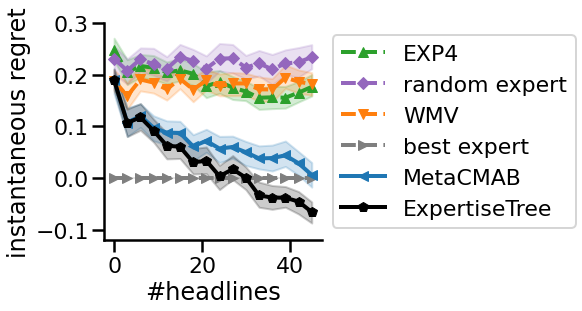

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/34 [00:00<?, ?it/s]

aggregators:   0%|          | 0/34 [00:00<?, ?it/s]

aggregators:   0%|          | 0/34 [00:00<?, ?it/s]

aggregators:   0%|          | 0/34 [00:00<?, ?it/s]

aggregators:   0%|          | 0/34 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7567 0.8476
MetaCMAB                            0.7155 0.7684
WMV                                 0.6042 0.5972
exp4                                0.5961 0.6006
expert_0                            0.7860 0.7810
expert_1                            0.7506 0.7362
expert_10                           0.6089 0.5976
expert_11                           0.6008 0.5920
expert_12                           0.5919 0.5762
expert_13                           0.5821 0.5526
expert_14                           0.5732 0.5560
expert_15                           0.5628 0.5550
expert_16                           0.5553 0.5436
expert_17                           0.5492 0.5386
expert_18                           0.5360 0.5166
expert_19                           0.5234 0.5094
expert_2                            0.7287 0.7146
expert_20                           0.5095 0.5004
ex

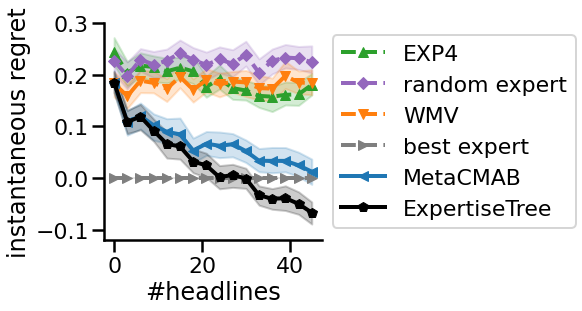

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/36 [00:00<?, ?it/s]

aggregators:   0%|          | 0/36 [00:00<?, ?it/s]

aggregators:   0%|          | 0/36 [00:00<?, ?it/s]

aggregators:   0%|          | 0/36 [00:00<?, ?it/s]

aggregators:   0%|          | 0/36 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7618 0.8554
MetaCMAB                            0.7213 0.7684
WMV                                 0.6047 0.5980
exp4                                0.5954 0.6000
expert_0                            0.7886 0.7818
expert_1                            0.7530 0.7360
expert_10                           0.6145 0.5992
expert_11                           0.6060 0.5866
expert_12                           0.5991 0.5908
expert_13                           0.5910 0.5676
expert_14                           0.5809 0.5606
expert_15                           0.5718 0.5548
expert_16                           0.5646 0.5526
expert_17                           0.5562 0.5390
expert_18                           0.5498 0.5448
expert_19                           0.5403 0.5228
expert_2                            0.7323 0.7158
expert_20                           0.5264 0.5062
ex

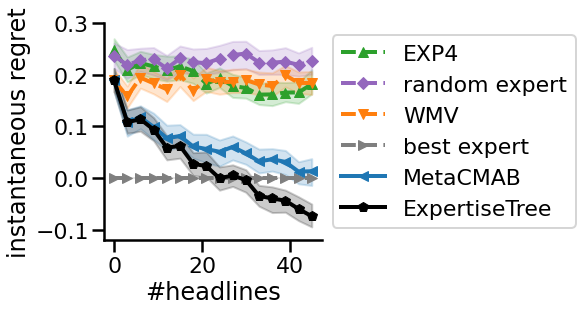

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/38 [00:00<?, ?it/s]

aggregators:   0%|          | 0/38 [00:00<?, ?it/s]

aggregators:   0%|          | 0/38 [00:00<?, ?it/s]

aggregators:   0%|          | 0/38 [00:00<?, ?it/s]

aggregators:   0%|          | 0/38 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7654 0.8674
MetaCMAB                            0.7255 0.7782
WMV                                 0.6053 0.5946
exp4                                0.5959 0.6056
expert_0                            0.7907 0.7850
expert_1                            0.7550 0.7410
expert_10                           0.6192 0.6042
expert_11                           0.6108 0.6010
expert_12                           0.6046 0.5844
expert_13                           0.5987 0.5852
expert_14                           0.5901 0.5708
expert_15                           0.5784 0.5576
expert_16                           0.5713 0.5582
expert_17                           0.5643 0.5468
expert_18                           0.5588 0.5436
expert_19                           0.5505 0.5378
expert_2                            0.7364 0.7152
expert_20                           0.5420 0.5254
ex

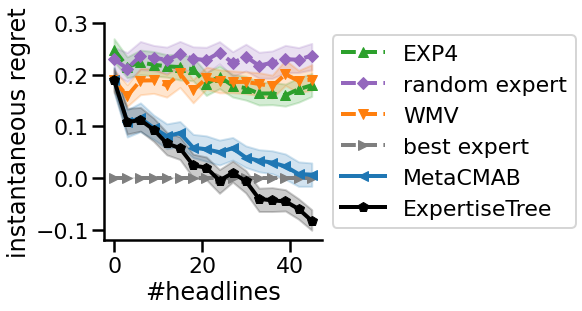

treatment:   0%|          | 0/5 [00:00<?, ?it/s]

aggregators:   0%|          | 0/40 [00:00<?, ?it/s]

aggregators:   0%|          | 0/40 [00:00<?, ?it/s]

aggregators:   0%|          | 0/40 [00:00<?, ?it/s]

aggregators:   0%|          | 0/40 [00:00<?, ?it/s]

aggregators:   0%|          | 0/40 [00:00<?, ?it/s]

algorithm                             mean   final
----------------------------------------------
ExpertiseTree                       0.7696 0.8678
MetaCMAB                            0.7293 0.7834
WMV                                 0.6054 0.5972
exp4                                0.5966 0.6062
expert_0                            0.7928 0.7856
expert_1                            0.7572 0.7438
expert_10                           0.6235 0.6094
expert_11                           0.6157 0.6036
expert_12                           0.6078 0.5918
expert_13                           0.6027 0.5906
expert_14                           0.5969 0.5816
expert_15                           0.5888 0.5654
expert_16                           0.5791 0.5616
expert_17                           0.5698 0.5480
expert_18                           0.5627 0.5504
expert_19                           0.5600 0.5520
expert_2                            0.7398 0.7208
expert_20                           0.5528 0.5346
ex

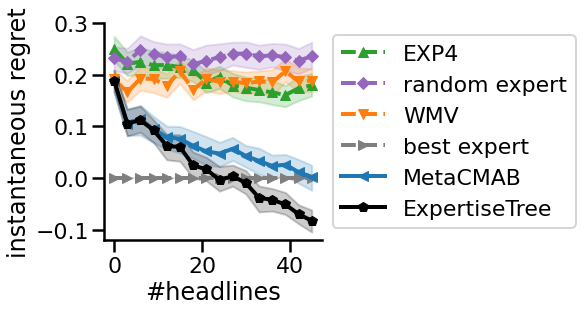

In [14]:
data_by_treatment = [prol_data.query("treatment == @treatment").sort_values(
    by=["trial", "arm", "expert_id"]) for treatment in range(5)]

SEED = 1234
n_simulations = 1000
simulations_per_process = 25
np.random.seed(SEED)
simulation_seeds = np.random.randint(2**16-1,size=np.ceil(n_simulations / simulations_per_process).astype(int))

for sim_n_experts in tqdm(subset_sizes,desc="subset sizes"):
    for treatment in trange(5, desc="treatment", disable=False):

        treatment_data = data_by_treatment[treatment].copy()
        N_ARMS = treatment_data.arm.nunique()
        N_EXPERTS = treatment_data.expert_id.nunique()
        T = treatment_data.trial.nunique()

        advice, outcomes = treatment_data[[
            "advice", "genuine",
        ]].values.T.reshape((-1, T, N_ARMS, N_EXPERTS))

        contexts = np.rollaxis(treatment_data[[
            "outcome:white", "outcome:male", "outcome:young"
        ]].abs().values.T.reshape((-1, T, N_ARMS, N_EXPERTS))[..., 0], 0, 3)

        aggregators = {
            "WMV": Collective(N_ARMS, GreedyPolicy(), sim_n_experts),
            "exp4": Exp4(N_ARMS, Exp3Policy(), sim_n_experts, gamma=np.sqrt(0.5 * np.log(sim_n_experts + 1) / (N_ARMS * T))),
            "MetaCMAB":  MetaCMAB(N_ARMS, GreedyPolicy(), sim_n_experts ),
            "ExpertiseTree": ExpertiseTree(N_ARMS, GreedyPolicy(), sim_n_experts),
        }
        for i in range(sim_n_experts):
            aggregators[f'expert_{i}'] = GreedyExpert(None, i)

        bar = tqdm(aggregators.items(), total=len(
            aggregators), disable=False, desc="aggregators")
        for k, agent in bar:
            dataset_key = f"{sim_n_experts} {treatment} {k}"
            bar.set_description(k)
            
            if  os.path.exists(hdf5_filename):
                with h5py.File(hdf5_filename, 'r') as hf:
                    if dataset_key in hf:
                        continue

            results = Parallel(n_jobs=8)(delayed(run_simulation)(
                advice, outcomes, contexts, agent, seed, sim_n_experts, 
                simulations_per_process if (i + 1) * simulations_per_process <= n_simulations else n_simulations - i * simulations_per_process) for i,seed in enumerate(simulation_seeds))
            results = np.array(results).reshape((-1, T))

            with h5py.File(hdf5_filename, 'a') as hf:
                if dataset_key in hf:
                    del hf[dataset_key]
                hf.create_dataset(dataset_key, data=results)

    print_summary(sim_n_experts)
    plot_subset_figures(sim_n_experts)

c:\intelpython3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


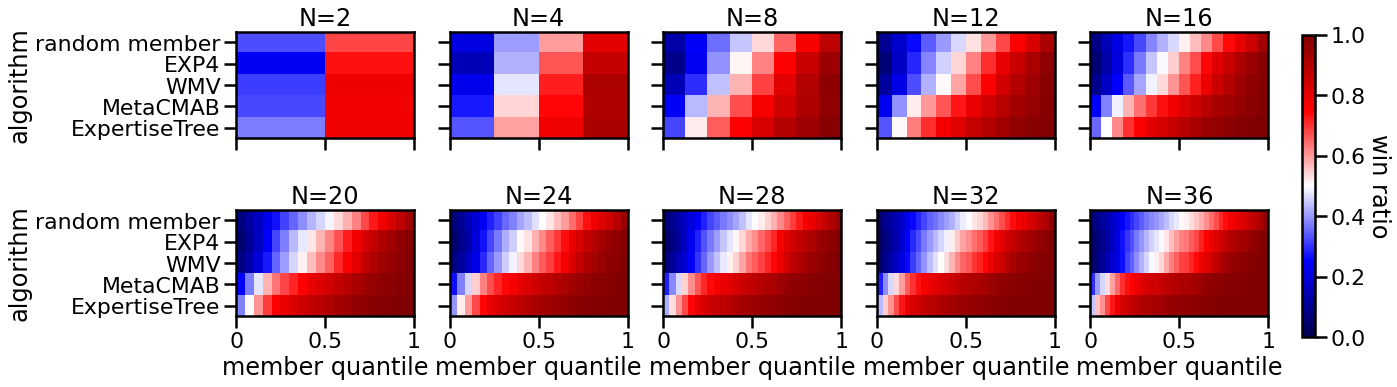

In [18]:

fig,axes = plt.subplots(2,5)
fig.set_size_inches(18.5, 6)
row_length=5
for n,subset_size in enumerate([2]+np.arange(4,37,4).tolist()):
    row_labels = ('ExpertiseTree','MetaCMAB',"WMV","exp4","random_expert")[::-1]
    proper_labels = ['ExpertiseTree',"MetaCMAB","WMV","EXP4","random member"][::-1]
    

    reference_results =  np.array([get_all_results(f'expert_{i}',subset_size)[...,:].mean(axis=-1) for i in range(subset_size)])
    alg_results = [get_all_results(k,subset_size)[...,:].mean(axis=-1) for k in row_labels]
    
    percent_scores=np.array([(((alg_results[j]>=reference_results)).mean(axis=1) + ((alg_results[j]>reference_results)).mean(axis=1))/2 for j in range(len(row_labels))])
    j=n%row_length
    i=n//row_length
    im = axes[i,j].imshow(percent_scores,aspect=.12,extent=[0,1,0,len(row_labels)],cmap="seismic",vmin=0,vmax=1)

    if j==0:
        axes[i,j].set_yticks(np.arange(len(row_labels))+.5, proper_labels[::-1])
        axes[i,j].set_ylabel("algorithm")
    else:
        axes[i,j].set_yticks(np.arange(len(row_labels))+.5, [""]*len(row_labels))
    if i==0:
        
        axes[i,j].set_xticklabels([])
    else:
        axes[i,j].set_xticklabels(['0','0.5','1'])

    if i==1:
        axes[i,j].set_xlabel("member quantile")
    axes[i,j].set_title(f"N={subset_size}")
    
cbar_ax = fig.add_axes([0.925, 0.125, 0.01, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)

cbar.ax.get_yaxis().labelpad = 25
cbar.set_label('win ratio', rotation=270)
plt.savefig(f"figures/quantile_heatmap.pdf",bbox_inches="tight")
plt.savefig(f"figures/quantile_heatmap.svg",bbox_inches="tight")
plt.show()


exp4 0.5926388888888889
random_expert 0.5608583333333335
WMV 0.6003868055555557
expert_0 0.7538451388888888
MetaCMAB 0.6781513888888888
ExpertiseTree 0.71155


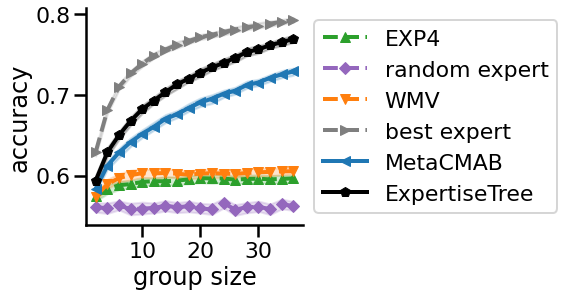

In [19]:

for alg_key, alg_color, alg_label, alg_marker in alg_styles:
    try:
        results = [get_all_results(alg_key,subset_size).mean(axis=-1) for subset_size in subset_sizes]
    except:
        continue
    means = [np.mean(result) for result in results]
    print(alg_key,np.mean(means))
    cis = np.array([bootstrap_ci(result) for result in results])
    
    plt.plot(subset_sizes,means,  color=alg_color, label=alg_label, 
             linestyle=":" if 'b' in alg_key else "--" if alg_label not in ("MetaCMAB", "ExpertiseTree") else "-", 
             linewidth=4, markersize=8 if alg_marker == 'D' else 10,
             marker=alg_marker)

    plt.fill_between(subset_sizes, cis[:,0],cis[:,1], color=alg_color, alpha=.2)


plt.xlabel("group size")
plt.ylabel("accuracy")
sns.despine()
plt.gca().set_box_aspect(1)
sns.despine(offset=0,)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/average_reward.pdf",bbox_inches="tight") 
plt.savefig("figures/average_reward.svg",bbox_inches="tight") 

In [20]:

for alg_key, alg_color, alg_label, alg_marker in alg_styles:
    
    try:
        results = [get_all_results("expert_0",subset_size)[:,-1]-get_all_results(alg_key,subset_size)[:,-1] for subset_size in subset_sizes]
    except:
        continue
    means = [np.mean(result) for result in results]
    print(alg_key,np.mean(means))
    cis = np.array([bootstrap_ci(result) for result in results])
    plt.plot(subset_sizes,means, color=alg_color, label=alg_label, 
             linestyle=":" if 'b' in alg_key else "--" if alg_label not in ("MetaCMAB", "ExpertiseTree") else "-", 
             linewidth=4, markersize=8 if alg_marker == 'D' else 10,
             marker=alg_marker)

    plt.fill_between(subset_sizes, cis[:,0],cis[:,1], color=alg_color, alpha=.2)


plt.xlabel("group size")
plt.ylabel("terminal regret")
plt.gca().set_box_aspect(1)
sns.despine(offset=0,)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/final_reward.pdf",bbox_inches="tight") 
plt.savefig("figures/final_reward.svg",bbox_inches="tight") 

exp4 0.15031111111111115
random_expert 0.19905555555555557
WMV 0.15064444444444444
